# Проект: Прогнозирование рейтинга отелей на основе отзывов

## PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle


**ИСХОДНЫЕ ДАННЫЕ:** 

Датасет, в котором содержатся сведения о 515_000 отзывов на отели Европы, первоначальная версия датасета содержит 17 полей со следующей информацией:

***hotel_address*** — адрес отеля;

***review_date*** — дата, когда рецензент разместил соответствующий отзыв;

***average_score*** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

***hotel_name*** — название отеля;

***reviewer_nationality*** — страна рецензента;

***negative_review*** — отрицательный отзыв, который рецензент дал отелю;

***review_total_negative_word_counts*** — общее количество слов в отрицательном отзыв;

***positive_review*** — положительный отзыв, который рецензент дал отелю;

***review_total_positive_word_counts*** — общее количество слов в положительном отзыве.

***reviewer_score*** — оценка, которую рецензент поставил отелю на основе своего опыта;

***total_number_of_reviews_reviewer_has_given*** — количество отзывов, которые рецензенты дали в прошлом;

***total_number_of_reviews*** — общее количество действительных отзывов об отеле;

***tags*** — теги, которые рецензент дал отелю;

***days_since_review*** — количество дней между датой проверки и датой очистки;

***additional_number_of_scoring*** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

***lat*** — географическая широта отеля;

***lng*** — географическая долгота отеля.
***

**ЗАДАНИЕ:**

Обученная модель ***должна предсказывать рейтинг отеля*** по данным сайта Booking на основе имеющихся в датасете данных. 

***

**МЕТРИКА:**

MAPE - средняя абсолютная ошибка в процентах, Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 

*** 

**ИНСТРУМЕНТЫ:**

Python,  Pandas, Numpy, Scikit-learn, SciPy, Statsmodels, Matplotlib, Seaborn, Plotly, NLTK, Geopy


***




In [762]:
!pip install geopy

In [763]:
!pip install nltk

In [764]:
# Импорт библиотек
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

from sklearn import preprocessing
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
#from sklearn.preprocessing import MinMaxScaler

import category_encoders as ce # импорт для работы с кодировщиком

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import re
import requests
import zipfile
import io
import os
import requests
import time

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer


In [765]:
!pip freeze > requirements.txt

In [766]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

## Загрузка данных

In [767]:
# Загрузка данных из файла hotels.csv
hotels = pd.read_csv('data/hotels.csv')
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [768]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [769]:
hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [770]:
# количество уникальных значений в каждом столбце
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1473
lng                                             1473
dtype: int64

In [771]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропуски NaN в датасете hotel: '

lat    2448
lng    2448
dtype: int64

## Очистка от пропущенных значений

Проверим наличие в датасете Nan и скрытых пустых значений (пустые строки и строки с пробелами)

In [772]:
# Проверяем наличие неявных пропусков в датасете, заменяем пустые строки и строки с пробелами на NaN
# Действие производим над копией датасета
df = hotels.copy()
df= df.replace(['', ' ', '  '], np.nan)

# Подсчет NaN значений в каждом столбце
nan_counts = df.isna().sum()

# Фильтруем только те столбцы, где есть NaN значения
nan_columns = nan_counts[nan_counts > 0]
    
# Проверяем, есть ли пропуски
if nan_columns.any():  # Проверяем, есть ли хотя бы один пропуск
    display("Столбцы датасета с пропусками (NaN и неявные пропуски) :")
    display(nan_columns)
else:
    display('Пропусков (NaN и неявных пропусков) в датасете нет')


'Столбцы датасета с пропусками (NaN и неявные пропуски) :'

reviewer_nationality     395
negative_review          606
positive_review          128
lat                     2448
lng                     2448
dtype: int64

Заполняем пустые значения признака reviewer_nationality модой

In [773]:
# Заменяем пустые строки и строки с пробелами на NaN
hotels['reviewer_nationality']= hotels['reviewer_nationality'].replace(['', ' '], np.nan)
display(f'Количество пустых значений в reviewer_nationality ДО обработки {hotels['reviewer_nationality'].isna().sum()}')

# Заполняем NaN наиболее частым значением (модой)
most_frequent_nationality = hotels['reviewer_nationality'].mode()[0]
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].fillna(most_frequent_nationality)
display(f'Количество пустых значений в reviewer_nationality ПОСЛЕ обработки {hotels['reviewer_nationality'].isna().sum()}')

'Количество пустых значений в reviewer_nationality ДО обработки 395'

'Количество пустых значений в reviewer_nationality ПОСЛЕ обработки 0'

Признаки negative_review и positive_review будут использованы для создания новых признаков, заполнение пропущенных значений на данном этапе - не требуется.                                                        

#### Заполняем пропущенные значения в признаках lat и lng через геокодер geopy по адресу отеля

Чтобы заполнить пропущенные значения в столбцах lat и lng на основе адреса отеля из столбца hotel_address, используем геокодирование. Для этого воспользуемся библиотекой geopy, которая позволяет преобразовывать адреса в координаты (широту и долготу).

In [774]:
# Создаем экземпляр геокодера
geolocator = Nominatim(user_agent="hotel_locator", timeout=10)  # Увеличиваем таймаут до 10 секунд

# Функция для геокодирования адреса отеля
def get_lat_lng(address):
    try:
        location = geolocator.geocode(address, timeout=10)  # Увеличиваем таймаут
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return get_lat_lng(address)  # Повторяем запрос в случае таймаута
    except Exception as e:
        display(f"Ошибка при геокодировании адреса '{address}': {e}")
        return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0,5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')


'Количество пропусков в lat: 2448'

'Количество пропусков в lng: 2448'

In [775]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name
grouped_missing_geo = missing_geo.groupby('hotel_name').size().reset_index(name='missing_count')

# Проверяем результат
display(grouped_missing_geo)

,hotel_name,missing_count
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,141
1,City Hotel Deutschmeister,63
2,Cordial Theaterhotel Wien,40
3,Derag Livinghotel Kaiser Franz Joseph Vienna,112
4,Fleming s Selection Hotel Wien City,496
5,Holiday Inn Paris Montmartre,47
6,Hotel Advance,26
7,Hotel Atlanta,285
8,Hotel City Central,421
9,Hotel Daniel Vienna,182


In [776]:
# Создаем экземпляр геокодера   
geolocator = Nominatim(user_agent="hotel_locator", timeout=10)  # Увеличиваем таймаут до 10 секунд

# Функция для геокодирования отеля по его на
def get_lat_lng_name(hotel_name):
    try:
        location = geolocator.geocode(hotel_name, timeout=10)  # Увеличиваем таймаут
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return get_lat_lng(hotel_name)  # Повторяем запрос в случае таймаута
    except Exception as e:
        display(f"Ошибка при геокодировании адреса '{hotel_name}': {e}")
        return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng_name(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0,5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')


'Количество пропусков в lat: 2448'

'Количество пропусков в lng: 2448'

In [777]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name
grouped_missing_geo = missing_geo.groupby('hotel_name').size().reset_index(name='missing_count')

# Проверяем результат
display(grouped_missing_geo)

,hotel_name,missing_count
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,141
1,City Hotel Deutschmeister,63
2,Cordial Theaterhotel Wien,40
3,Derag Livinghotel Kaiser Franz Joseph Vienna,112
4,Fleming s Selection Hotel Wien City,496
5,Holiday Inn Paris Montmartre,47
6,Hotel Advance,26
7,Hotel Atlanta,285
8,Hotel City Central,421
9,Hotel Daniel Vienna,182


#### Если координаты для этих отелей из списка не были найдены через геокодер geopy - используем альтернативный геокодер photon

In [778]:
# Заполняем пропущенные значения через геокодер Photon
def get_lat_lng_photon(address):
    url = f"https://photon.komoot.io/api/?q={address}"

    response = requests.get(url)
    if response.status_code == 200:
        results = response.json()
        if results['features']:
            location = results['features'][0]['geometry']['coordinates']
            return location[1], location[0]  # Возвращаем (широта, долгота)
    return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng_photon(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0.5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')
# ожидание 2-3 минуты - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'Количество пропусков в lat: 1990'

'Количество пропусков в lng: 1990'

##### Проверка списка отелей с пропущенными значениями в lat и lng

In [779]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Проверяем результат
grouped_missing_geo

,hotel_name,hotel_address
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria
1,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...
2,Cordial Theaterhotel Wien,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...
3,Derag Livinghotel Kaiser Franz Joseph Vienna,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...
4,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...
5,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
6,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
7,Hotel Daniel Vienna,Landstra er G rtel 5 03 Landstra e 1030 Vienna...
8,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria
9,Hotel Pension Baron am Schottentor,W hringer Stra e 12 09 Alsergrund 1090 Vienna ...


##### Если координаты для этих отелей из списка не были найдены через геокодеры geopy и photon - используем словарь с координатами отелей для заполнения.

In [780]:
# Заполняем пропущенные значения через словарь
start_time = time.time()

coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

def get_coord(row):
    if pd.isna(row.lat):
        row.lat = coord_dict[row.hotel_name][0]
        row.lng = coord_dict[row.hotel_name][1]
        return row
    else: 
        return row

hotels = hotels.apply(lambda row: get_coord(row), axis=1)

#start_time = time.time()
display("--- %s seconds ---" % (time.time() - start_time))

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')
# ожидание 12-15 секунд - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'--- 13.719173669815063 seconds ---'

'Количество пропусков в lat: 0'

'Количество пропусков в lng: 0'

In [781]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

In [782]:
# сохраняем датафрейм с без пропусков
#hotels.to_csv('data/hotels_without_nan.csv', index=False)

## Создание новых признаков


### Создание новых признаков на основе данных столбца tags (признак есть - 1, признака нет - 0)

1. Признак на основе типа путешествия

    - 'Leisure trip'

    - 'Business trip'

2. Способ бронирования

    - 'Submitted from a mobile device'

3. Признак на основе кол-ва посетителей отеля в группе.

    - 'Solo traveler'
  
    - 'Couple'
  
    - 'Group'
  
    - 'Family with young children'
  
    - 'Family with older children'


In [783]:
hotels['leisure_trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['business_trip'] = hotels['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
hotels['mobile_booking'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['solo_traveler'] = hotels['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
hotels['couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
hotels['group'] = hotels['tags'].apply(lambda x: 1 if 'Group' in x else 0)
hotels['family_with_young_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)
hotels['family_with_older_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)

### Создание признака количества ночей пребывания в отеле (stayed_nights) на основе данных столбца tags


In [784]:
# Создаем новую колонку stayed_nights, извлекая числовое значение перед словом "night"
hotels['stayed_nights'] = hotels['tags'].str.extract(r'(\d+)\s*night', expand=False)

# Преобразуем в числовой формат
hotels['stayed_nights'] = pd.to_numeric(hotels['stayed_nights'], errors='coerce')

# Заполнение пропущенных значений медианой
hotels['stayed_nights'] = hotels['stayed_nights'].fillna(hotels['stayed_nights'].median())

### Создание признака страны отеля (hotel_country) на основании адреса отеля


Выделяем признак страны отеля на основании адреса отеля

In [785]:
# URL к ZIP-архиву со списком стран
url = 'https://cdn-std.droplr.net/files/acc_432097/8xjTtQ?download&response-content-disposition=attachment%3B%20filename%3Dcountry-city-and-state-csv.zip'

# Загружаем ZIP-архив
response = requests.get(url)
display(f'Country database download response status code: {response.status_code}')

# Проверяем, что запрос успешен
if response.status_code == 200:
    # Открываем ZIP-архив
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Извлекаем файл countries.csv
        with z.open('countries.csv') as f:
            # Загружаем данные в DataFrame
            countries_df = pd.read_csv(f)
            # Извлекаем первую колонку с названиями стран
            country_names = countries_df.iloc[:, 0].tolist()
            #display(country_names)
else:
    display(f"Ошибка загрузки: {response.status_code}")

# формирваем список стран
if not country_names: 
    countries = country_names
else:
    countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 
                 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 
                 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 
                 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 
                 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 
                 'Chad', 'Chile', "People's Republic of China", 'Colombia', 'Comoros', 'Congo - Kinshasa', 
                 'Congo - Brazzaville', 'Costa Rica', "Cote d'Ivoire (The Ivory Coast)", 'Croatia', 'Cuba', 
                 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 
                 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 
                 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 
                 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 
                 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 
                 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'North Korea', 
                 'South Korea', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 
                 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Madagascar', 'Malawi', 
                 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 
                 'Mexico', 'Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 
                 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 
                 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 
                 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 
                 'Romania', 'Russia', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 
                 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 
                 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 
                 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'Spain', 
                 'Sri Lanka', 'Sudan', 'Suriname', 'Swaziland', 'Sweden', 'Switzerland', 'Syria', 
                 'Tajikistan', 'Tanzania', 'Thailand', 'Timor-Leste (East Timor)', 'Togo', 'Tonga', 
                 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 
                 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay', 'Uzbekistan', 
                 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe', 
                 'Abkhazia', 'Taiwan', 'Nagorno-Karabakh', 'Northern Cyprus', 'Pridnestrovie (Transnistria)', 
                 'Somaliland', 'South Ossetia', 'Ashmore and Cartier Islands', 'Christmas Island', 
                 'Cocos (Keeling) Islands', 'Coral Sea Islands', 'Heard Island and McDonald Islands', 
                 'Norfolk Island', 'New Caledonia', 'French Polynesia', 'Mayotte', 'Saint Barthelemy', 
                 'Saint Martin', 'Saint Pierre and Miquelon', 'Wallis and Futuna', 
                 'French Southern and Antarctic Lands', 'Clipperton Island', 'Bouvet Island', 
                 'Cook Islands', 'Niue', 'Tokelau', 'Guernsey', 'Isle of Man', 'Jersey', 'Anguilla', 
                 'Bermuda', 'British Indian Ocean Territory', 'British Sovereign Base Areas', 
                 'British Virgin Islands', 'Cayman Islands', 'Falkland Islands (Islas Malvinas)', 
                 'Gibraltar', 'Montserrat', 'Pitcairn Islands', 'Saint Helena', 
                 'South Georgia & South Sandwich Islands', 'Turks and Caicos Islands', 
                 'Northern Mariana Islands', 'Puerto Rico', 'American Samoa', 'Baker Island', 
                 'Guam', 'Howland Island', 'Jarvis Island', 'Johnston Atoll', 'Kingman Reef', 
                 'Midway Islands', 'Navassa Island', 'Palmyra Atoll', 'U.S. Virgin Islands', 
                 'Wake Island', 'Hong Kong', 'Macau', 'Faroe Islands', 'Greenland', 'French Guiana', 
                 'Guadeloupe', 'Martinique', 'Reunion', 'Aland', 'Aruba', 'Netherlands Antilles', 
                 'Svalbard', 'Ascension', 'Tristan da Cunha', 'Australian Antarctic Territory', 
                 'Ross Dependency', 'Peter I Island', 'Queen Maud Land', 'British Antarctic Territory']
    

# Функция для извлечения страны из адреса
def extract_country(address):
    # Проверяем каждую страну в списке
    for country in countries:
        if country in address:
            return country
    return None

# Применяем функцию к датафрейму
hotels['hotel_country'] = hotels['hotel_address'].apply(extract_country)

# Заполнение пропущенных значений модой
hotels['hotel_country'] = hotels['hotel_country'].fillna(hotels['hotel_country'].mode()[0])
# ожидание 6-10 секунд - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'Country database download response status code: 200'

In [786]:
hotels['hotel_country'].value_counts()

hotel_country
United Kingdom    196774
France             44830
Spain              44643
Netherlands        43006
Austria            29178
Italy              27883
Nicaragua            292
Palau                197
Name: count, dtype: int64

Дополнительная проверка на пропуски значений

In [787]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

In [788]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

#### Кодирование признаков на основе даты отзыва

In [789]:
#Преобразуем признак review_date в признаки на основе даты отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day

#Преобразуем признак review_date в признак сезона весна (1), лето (2), осень (3), зима (4)
hotels['season'] = hotels['review_month'].apply(lambda x: 1 if x in [3, 4, 5] else
                                              2 if x in [6, 7, 8] else
                                              3 if x in [9, 10, 11] else
                                              4 if x in [12, 1, 2] else
                                              0)
#Преобразуем признак review_date в  признак дня недели
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek

In [790]:
# Проверяем, совпадает ли страна рецензента с названием страны в адресе отеля и присваиваем 1 или 0
#hotels['reviewer_abroad'] = hotels.apply(
#    lambda row: 0 if row['reviewer_nationality'] in row['hotel_address'] else 1, axis=1
#)

# неважный признак, внутрениие путешествия составляют 0,1% от всей выборки


In [791]:
# Преобразуем признак days_since_review в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

#### Кодирование признака reviewer_nationality бинарным способом BinaryEncoder

In [792]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

#### Кодирование признака hotel_country бинарным способом BinaryEncoder

In [793]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_country']) 
type_bin = bin_encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [794]:
# модель на признаках с dtypes "object" обучаться не будет, выберем их для проверки
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
display(object_columns)

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_country']

In [795]:
# список колонок датафрейма
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'leisure_trip', 'business_trip',
       'mobile_booking', 'solo_traveler', 'couple', 'group',
       'family_with_young_children', 'family_with_older_children',
       'stayed_nights', 'hotel_country', 'review_year', 'review_month',
       'review_day', 'season', 'day_of_week', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'hotel_country_0', 'hotel_country_1',
       'hotel_country_2', 'hotel_

In [796]:
# информация о датафрейме
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [797]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

### Решение заданий по разделу 4 (на выполнение проекта не влияет)

In [798]:
display(f'Количество уникальных отелей: {hotels["hotel_name"].nunique()}')
display(f'Дата начала отзывов: {hotels["review_date"].min()}')  
display(f'Дата окончания отзывов: {hotels["review_date"].max()}')

'Количество уникальных отелей: 1492'

'Дата начала отзывов: 2015-08-04 00:00:00'

'Дата окончания отзывов: 2017-08-03 00:00:00'

In [799]:
# выполнение задания по блоку 4
# Копирууем датасет для применения explode()
df = hotels.copy()

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

df['tags_n'] = df['tags'].apply(rev_func)
df.head()
display(f'Количество уникальных тегов: {df["tags_n"].explode().nunique()}')

'Количество уникальных тегов: 2368'

In [800]:
# Фильтруем теги, содержащие слово "night"
# Используем explode и регулярное выражение для поиска 'night' или 'nights' перед которыми стоит число
night_tags = df['tags_n'].explode()[df['tags_n'].explode().str.contains(r'\b\d+\s+(night|nights)\b', case=False, regex=True)]

#night_tags = df['tags_n'].explode().str.extract(r'(\b\d+\s+(night|nights)\b)', flags=re.IGNORECASE)

# Получаем распределение по количества ночей пребывания в отеле
night_counts = night_tags.value_counts()
display(f'Распределение по количеству ночей пребывания в отеле:')
display(night_counts)

C:\Users\stepu\AppData\Local\Temp\ipykernel_39660\3746712949.py:3: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



'Распределение по количеству ночей пребывания в отеле:'

tags_n
Stayed 1 night                                145373
Stayed 2 nights                               100263
Stayed 3 nights                                72000
Stayed 4 nights                                35748
Stayed 5 nights                                15611
Stayed 6 nights                                 7399
Stayed 7 nights                                 5549
Stayed 8 nights                                 1910
Stayed 9 nights                                  966
Stayed 10 nights                                 663
Stayed 11 nights                                 306
Stayed 12 nights                                 217
Stayed 14 nights                                 184
Stayed 13 nights                                 174
Stayed 15 nights                                  87
Stayed 16 nights                                  38
Stayed 17 nights                                  27
Stayed 18 nights                                  24
Stayed 19 nights                       

In [801]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [802]:
# Создаем новую колонку stayed_nights, извлекая числовое значение перед словом "night" или "nights"
# Применяем explode для разбивки списка на отдельные строки
exploded_hotels = hotels.explode('tags')

# Извлекаем число перед 'night' или 'nights'
stayed_nights = exploded_hotels['tags'].str.extract(r'(\d+)\s*(night|nights)', expand=False)

# Присваиваем найденные значения обратно в новый столбец 'stayed_nights'
# Используем groupby для восстановления индекса
hotels['stayed_nights'] = stayed_nights[0].groupby(stayed_nights.index).first()

# Преобразуем тип данных в int (если необходимо)
hotels['stayed_nights'] = hotels['stayed_nights'].astype(float)

# Заполняем пропуски медианой
hotels['stayed_nights'] = hotels['stayed_nights'].fillna(hotels['stayed_nights'].median())

Создаем дополнительные признаки из текстовых данных в negative_review и positive_review, с использованием библиотеки NLTK. 
Извлекаем признаки: 
- количество слов, 
- количество уникальных слов, 
- средняя длина слов, 
- оценка положительности слов,
- оценка отрицательности слов

In [803]:
# Указываем желательно короткий путь к папке
nltk_data_dir = './nltk_data'
#nltk_data_dir = 'D:/nltk_data'  

# Создаем папку, если она не существует
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Загрузка необходимых ресурсов NLTK в указанную папку
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

# Установка переменной окружения
#os.environ['NLTK_DATA'] = nltk_data_dir

# Установка пути для NLTK
#nltk.data.path = [nltk_data_dir]  # Оставляем только нужный путь

# Установка пути для NLTK
nltk.data.path.append(nltk_data_dir)  # Добавляем путь к nltk_data


# Инициализация анализатора настроений
sia = SentimentIntensityAnalyzer()

# Функция для создания признаков
def extract_features(row):
    # Объединяем положительные и отрицательные отзывы
    combined_reviews = row['negative_review'] + ' ' + row['positive_review']
    
    # Токенизация
    tokens = word_tokenize(combined_reviews.lower(), language='english', preserve_line=True)
    #tokens = word_tokenize(combined_reviews.lower())
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Признаки
    num_words = len(filtered_tokens)  # Количество слов
    num_unique_words = len(set(filtered_tokens))  # Количество уникальных слов
    avg_word_length = sum(len(word) for word in filtered_tokens) / num_words if num_words > 0 else 0  # Средняя длина слова
    positive_score = sia.polarity_scores(row['positive_review'])['compound']  # Оценка положительности
    negative_score = sia.polarity_scores(row['negative_review'])['compound']  # Оценка отрицательности
    
    return pd.Series([num_words, num_unique_words, avg_word_length, positive_score, negative_score])

# Применяем функцию к каждой строке датафрейма
hotels[['num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']] = hotels.apply(extract_features, axis=1)

# ожидание 5-7 минут - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to ./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Дополнительная проверка датасета на пропуски значений

In [804]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

## Преобразование признаков

Сформируем описание числовых признаков

In [805]:
scaling_columns = ['total_number_of_reviews', 'review_total_negative_word_counts', 
       'total_number_of_reviews_reviewer_has_given',
       'review_total_positive_word_counts', 'average_score',  
       'additional_number_of_scoring',  'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']

hotels[scaling_columns].describe()

,total_number_of_reviews,review_total_negative_word_counts,total_number_of_reviews_reviewer_has_given,review_total_positive_word_counts,average_score,additional_number_of_scoring,num_words,num_unique_words,avg_word_length,positive_score,negative_score
count,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,2743.992042,18.538988,7.17725,17.776985,8.397231,498.246536,18.841982,17.437329,6.051571,0.593396,-0.208919
std,2316.457018,29.703369,11.05442,21.726141,0.547881,500.258012,19.001584,16.061170,0.833536,0.342616,0.453625
min,43.000000,0.000000,1.00000,0.000000,5.200000,1.000000,0.000000,0.000000,0.000000,-0.983200,-0.998100
25%,1161.000000,2.000000,1.00000,5.000000,8.100000,169.000000,7.000000,7.000000,5.500000,0.353500,-0.709600
50%,2134.000000,9.000000,3.00000,11.000000,8.400000,342.000000,13.000000,13.000000,5.960000,0.708900,-0.177900
75%,3613.000000,23.000000,8.00000,22.000000,8.800000,660.000000,24.000000,22.000000,6.500000,0.883400,0.000000
max,16670.000000,408.000000,355.00000,395.000000,9.800000,2682.000000,381.000000,266.000000,69.666667,0.999300,0.996400


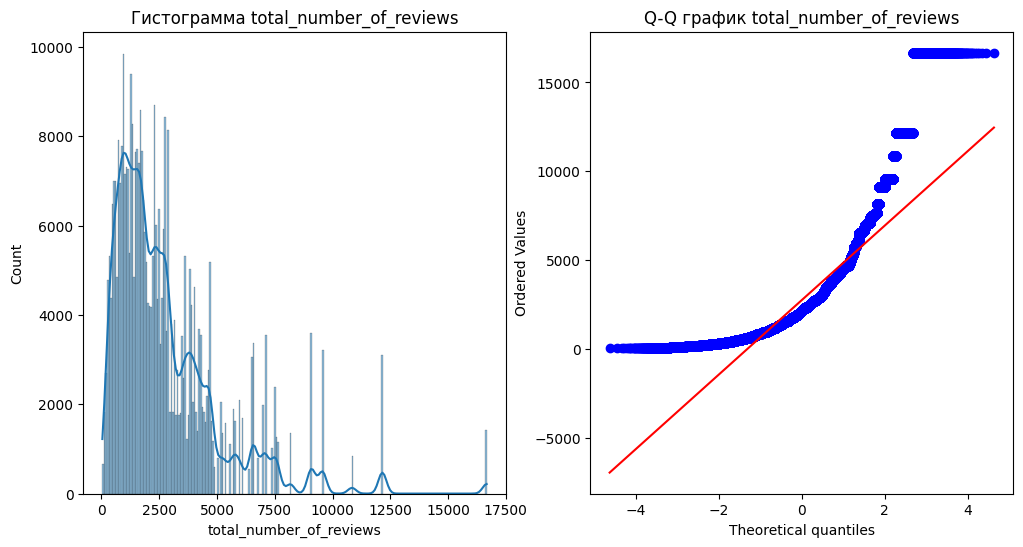

Тест Колмогорова-Смирнова для total_number_of_reviews: Статистика=0.144, p-значение=0.000
Распределение total_number_of_reviews не нормально (отвергаем H0)




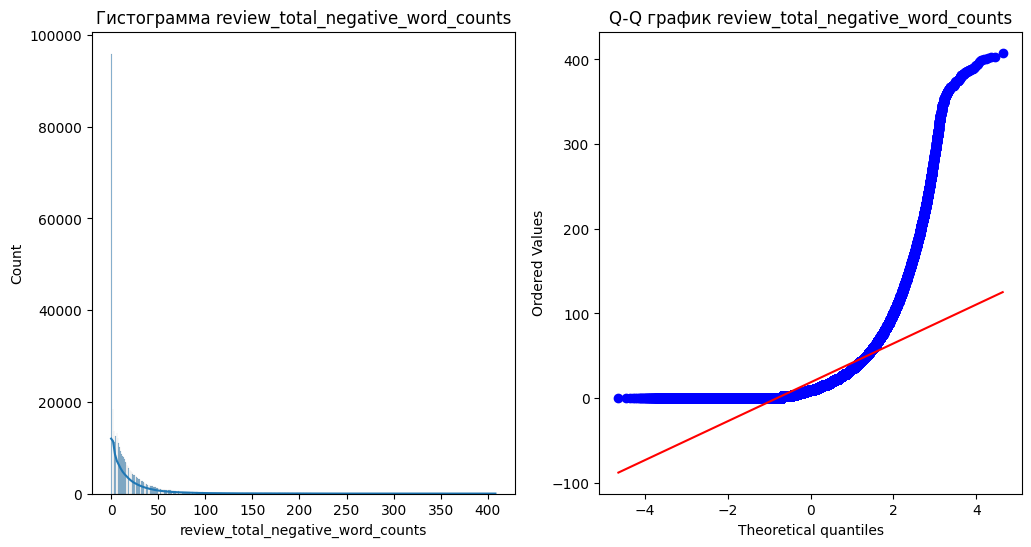

Тест Колмогорова-Смирнова для review_total_negative_word_counts: Статистика=0.266, p-значение=0.000
Распределение review_total_negative_word_counts не нормально (отвергаем H0)




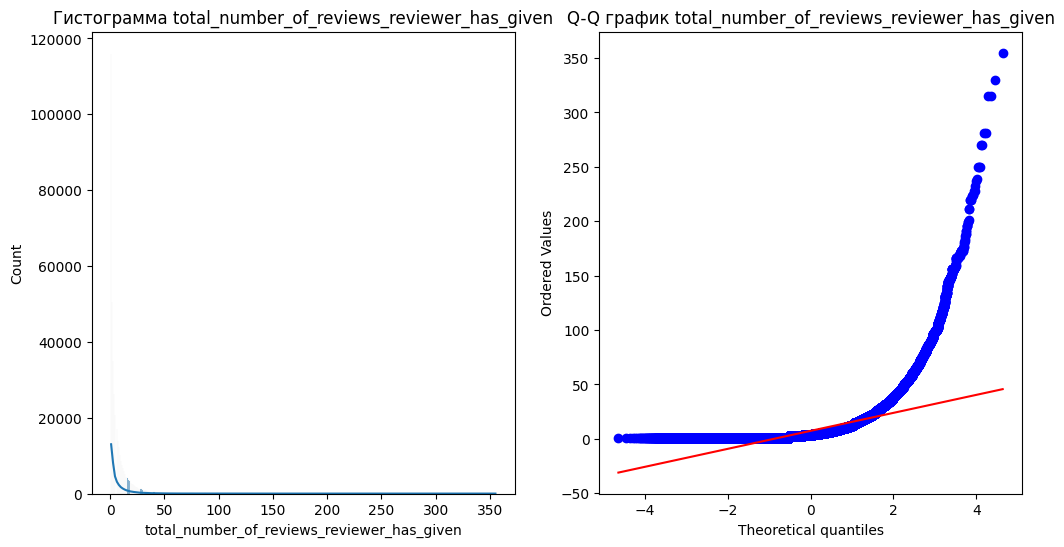

Тест Колмогорова-Смирнова для total_number_of_reviews_reviewer_has_given: Статистика=0.288, p-значение=0.000
Распределение total_number_of_reviews_reviewer_has_given не нормально (отвергаем H0)




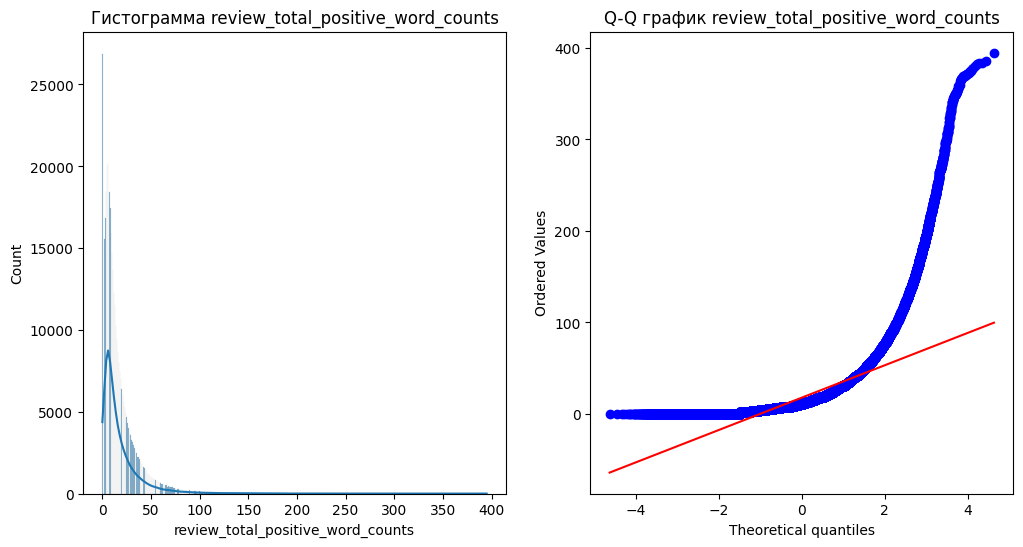

Тест Колмогорова-Смирнова для review_total_positive_word_counts: Статистика=0.207, p-значение=0.000
Распределение review_total_positive_word_counts не нормально (отвергаем H0)




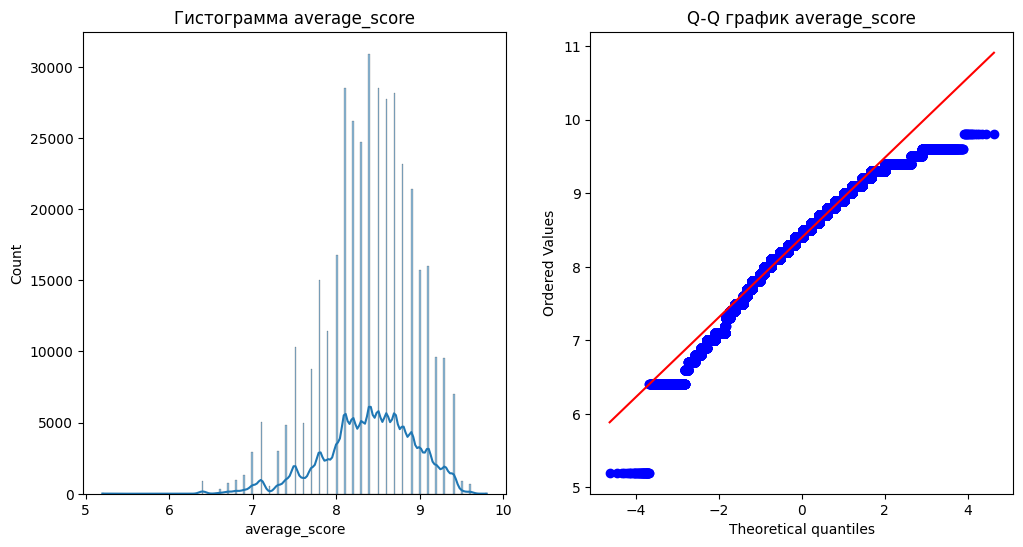

Тест Колмогорова-Смирнова для average_score: Статистика=0.070, p-значение=0.000
Распределение average_score не нормально (отвергаем H0)




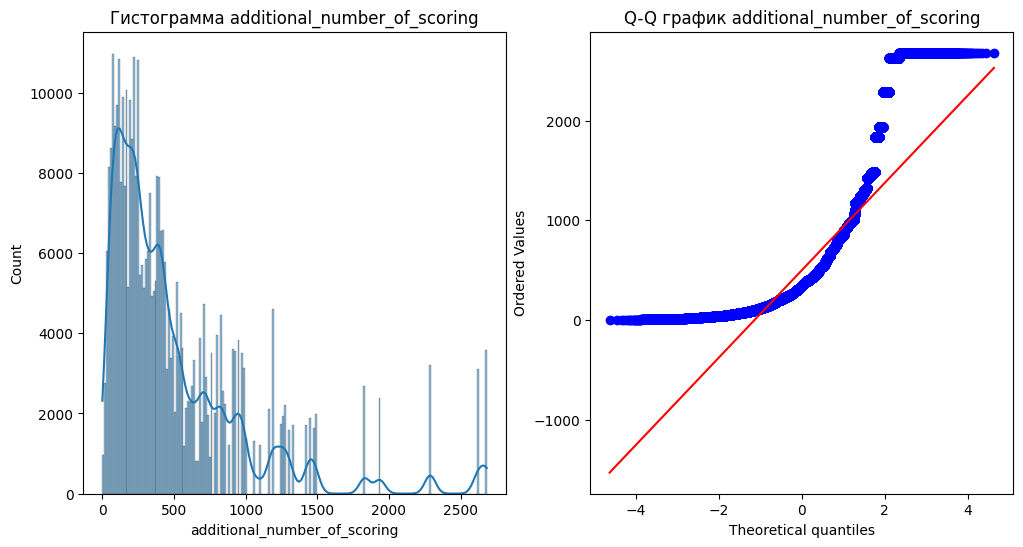

Тест Колмогорова-Смирнова для additional_number_of_scoring: Статистика=0.168, p-значение=0.000
Распределение additional_number_of_scoring не нормально (отвергаем H0)




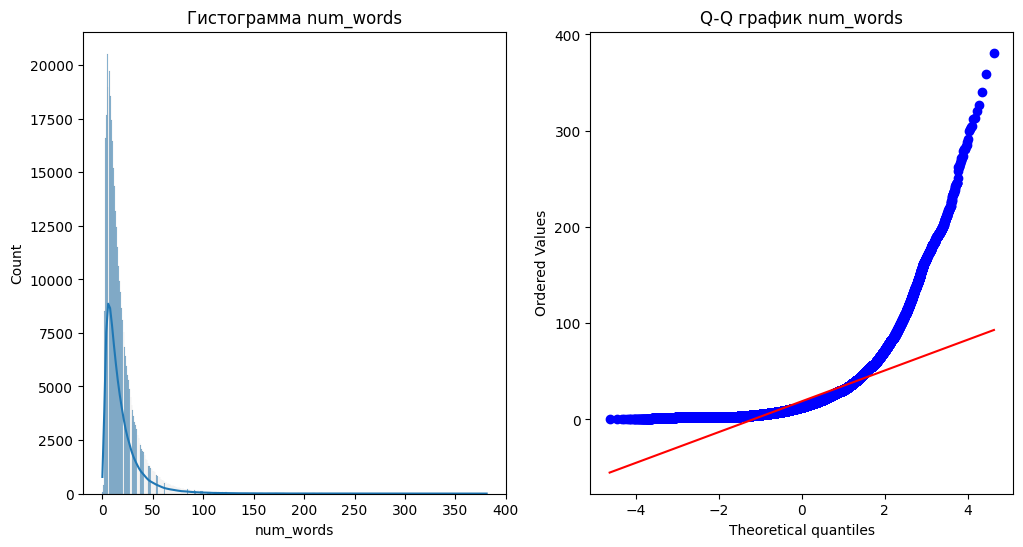

Тест Колмогорова-Смирнова для num_words: Статистика=0.187, p-значение=0.000
Распределение num_words не нормально (отвергаем H0)




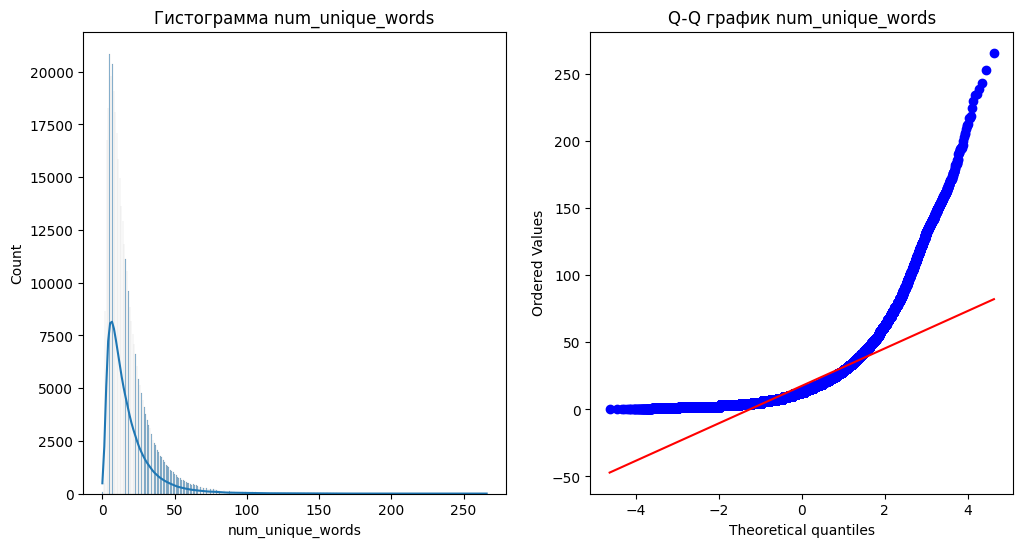

Тест Колмогорова-Смирнова для num_unique_words: Статистика=0.167, p-значение=0.000
Распределение num_unique_words не нормально (отвергаем H0)




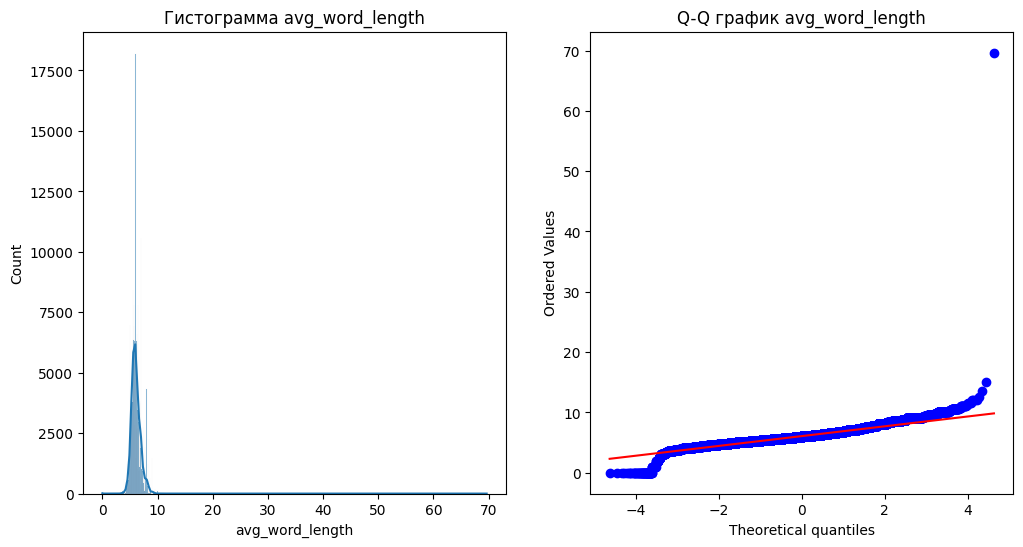

Тест Колмогорова-Смирнова для avg_word_length: Статистика=0.077, p-значение=0.000
Распределение avg_word_length не нормально (отвергаем H0)




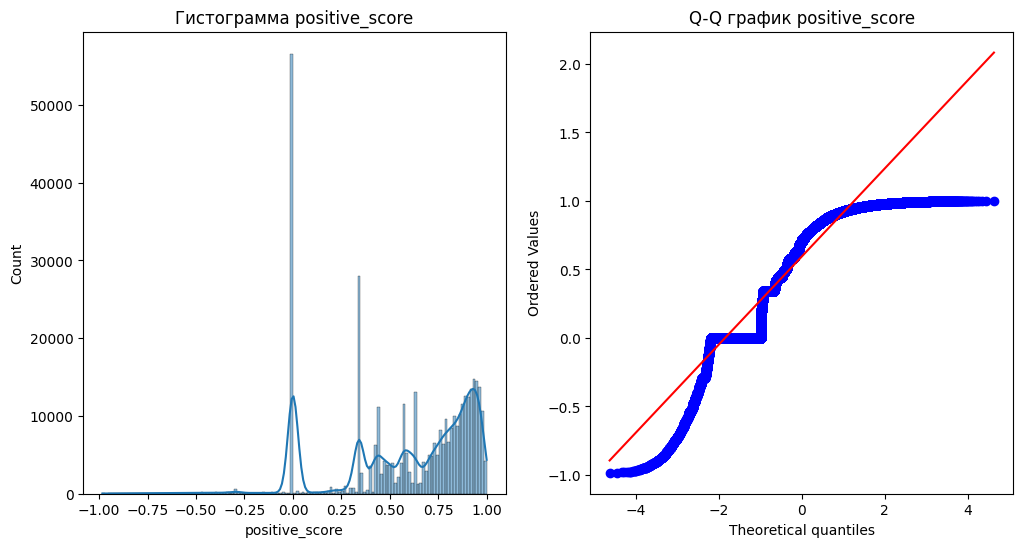

Тест Колмогорова-Смирнова для positive_score: Статистика=0.137, p-значение=0.000
Распределение positive_score не нормально (отвергаем H0)




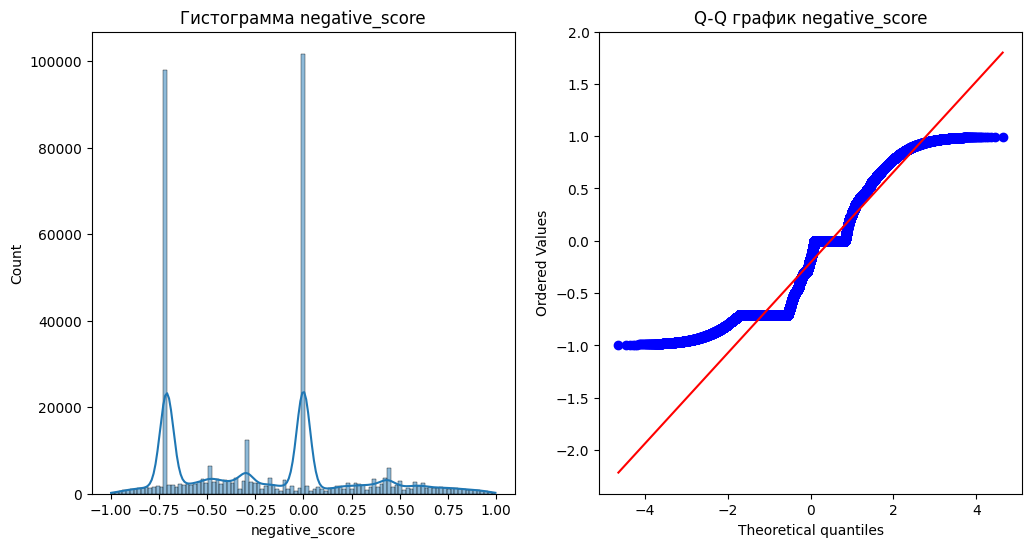

Тест Колмогорова-Смирнова для negative_score: Статистика=0.156, p-значение=0.000
Распределение negative_score не нормально (отвергаем H0)




In [806]:
# Функция для проверки нормальности с использованием теста Колмогорова-Смирнова, для значений более 5000
def check_normality(df, columns):
    for column in columns:
        # Графический метод: гистограмма
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Гистограмма {column}')
        
        # Q-Q график
        plt.subplot(1, 2, 2)
        stats.probplot(df[column], dist="norm", plot=plt)
        plt.title(f'Q-Q график {column}')
        
        plt.show()
        
        # Статистический тест: тест Колмогорова-Смирнова
        stat, p = stats.kstest(df[column], 'norm', args=(df[column].mean(), df[column].std()))
        print(f'Тест Колмогорова-Смирнова для {column}: Статистика={stat:.3f}, p-значение={p:.3f}')
        
        # Интерпретация результата
        alpha = 0.05
        if p > alpha:
            print(f'Распределение {column} нормально (не отвергаем H0)')
        else:
            print(f'Распределение {column} не нормально (отвергаем H0)')
        print('\n')

# Проверяем нормальность для указанных столбцов
check_normality(hotels, scaling_columns)

### Нормализация и стандартизация

Распределение отличается от нормального, есть выбросы - поэтому для нормализации используем методы RobustScaler или PowerTransformer

Для проверки влияния на MAPE проведем также сравнение методов нормализации и сопоставим метрики.

Итоговые метрики MAPE для разных методов нормализации: 
- 0.12533206314154807 - RobustScaler
- 0.12542054975340974 - MinMaxScaler
- 0.12482383153680582 - PowerTransformer

Выбираем метод нормализации PowerTransformer

In [807]:
# scaling_columns = ['total_number_of_reviews', 'review_total_negative_word_counts', 
#        'total_number_of_reviews_reviewer_has_given',
#        'review_total_positive_word_counts', 'average_score',  
#        'additional_number_of_scoring',  'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']

# инициализируем нормализатор RobustScaler
#scaler = preprocessing.RobustScaler()

# инициализируем нормализатор MinMaxScaler
#scaler = preprocessing.MinMaxScaler()

# Применяем RobustScaler только к выбранным столбцам
#hotels[scaling_columns] = scaler.fit_transform(hotels[scaling_columns])


# Проверим нормализацию с помощью PowerTransformer и проверим метрики
# Инициализируем нормализатор PowerTransformer
scaler = preprocessing.PowerTransformer(method='yeo-johnson')  # или method='box-cox' если данные положительные

# Применяем PowerTransformer только к выбранным столбцам
hotels[scaling_columns] = scaler.fit_transform(hotels[scaling_columns])

#print("Параметры преобразования:", scaler.lambdas_)

### Проверяем нормальность для указанных столбцов после шкалирования

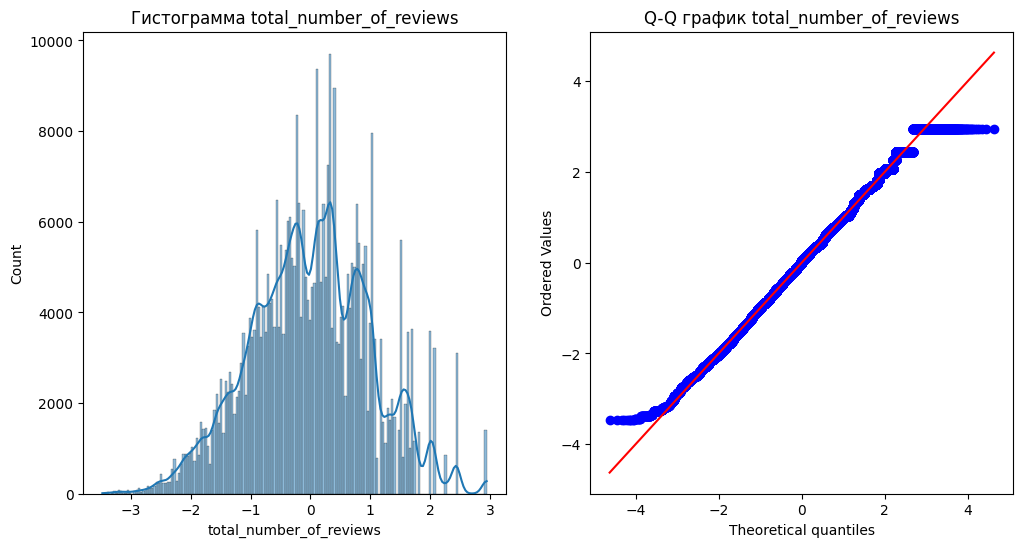

Тест Колмогорова-Смирнова для total_number_of_reviews: Статистика=0.021, p-значение=0.000
Распределение total_number_of_reviews не нормально (отвергаем H0)




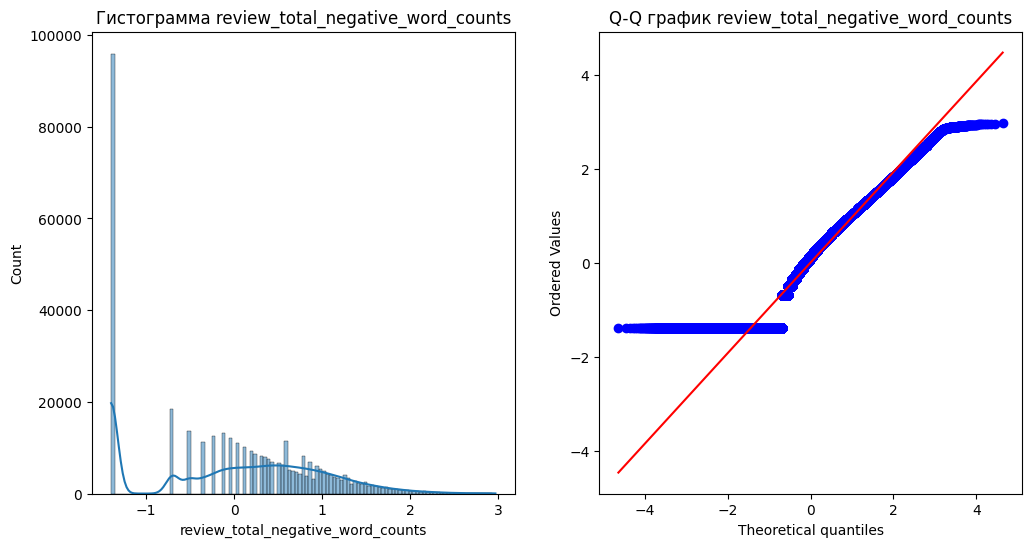

Тест Колмогорова-Смирнова для review_total_negative_word_counts: Статистика=0.167, p-значение=0.000
Распределение review_total_negative_word_counts не нормально (отвергаем H0)




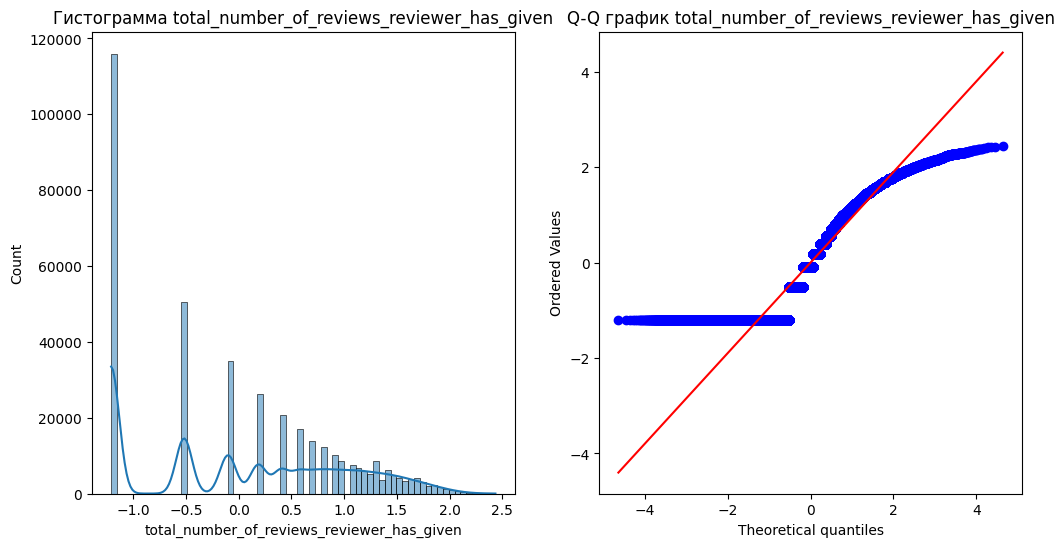

Тест Колмогорова-Смирнова для total_number_of_reviews_reviewer_has_given: Статистика=0.186, p-значение=0.000
Распределение total_number_of_reviews_reviewer_has_given не нормально (отвергаем H0)




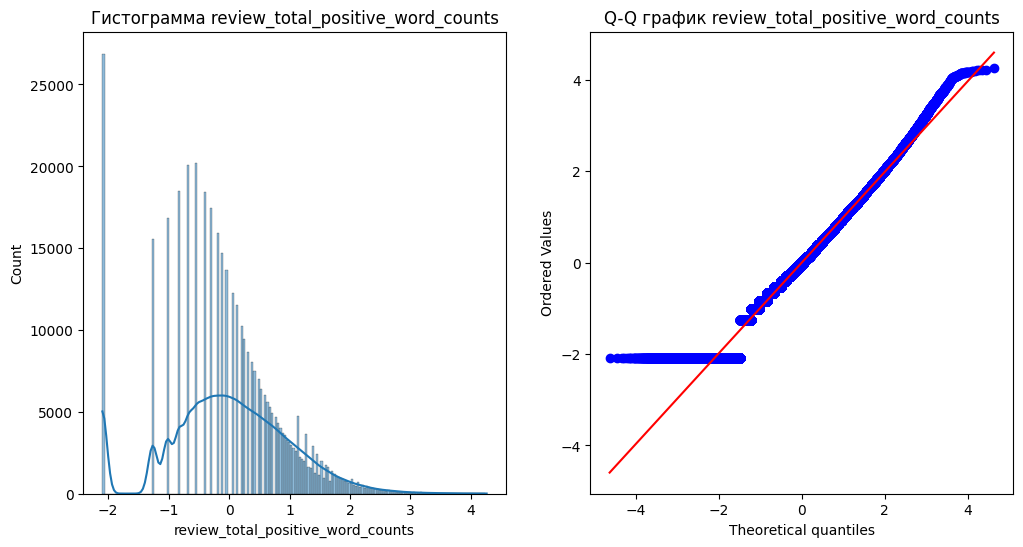

Тест Колмогорова-Смирнова для review_total_positive_word_counts: Статистика=0.051, p-значение=0.000
Распределение review_total_positive_word_counts не нормально (отвергаем H0)




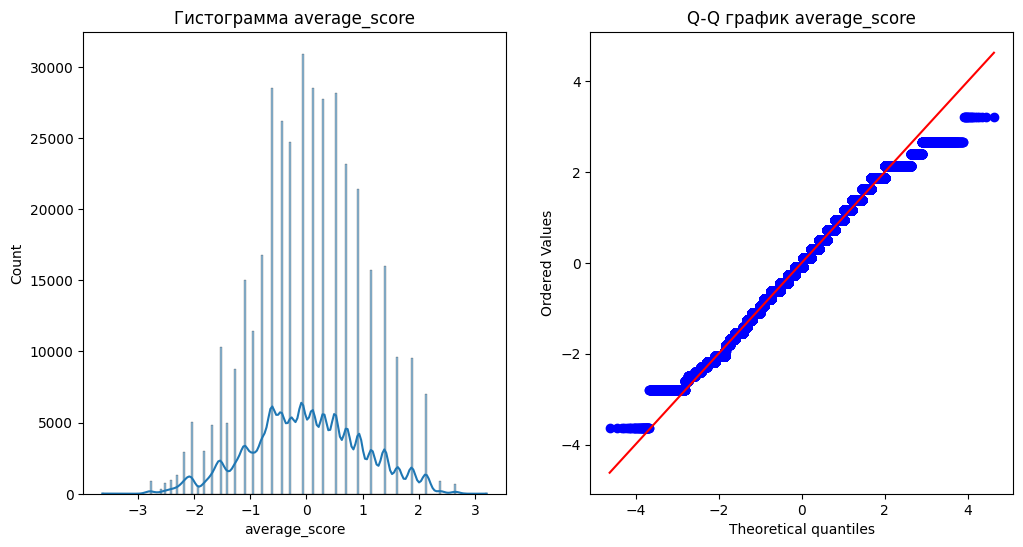

Тест Колмогорова-Смирнова для average_score: Статистика=0.046, p-значение=0.000
Распределение average_score не нормально (отвергаем H0)




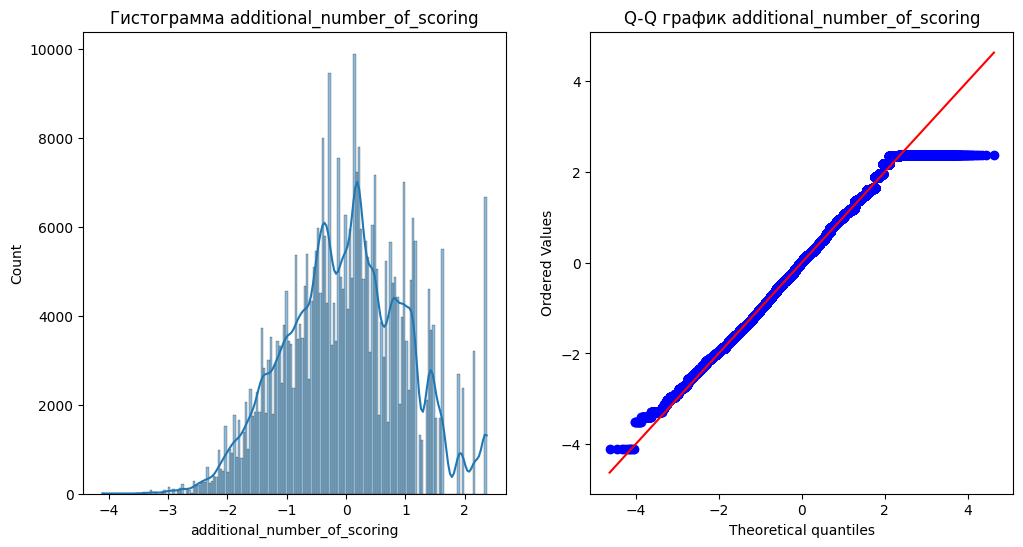

Тест Колмогорова-Смирнова для additional_number_of_scoring: Статистика=0.020, p-значение=0.000
Распределение additional_number_of_scoring не нормально (отвергаем H0)




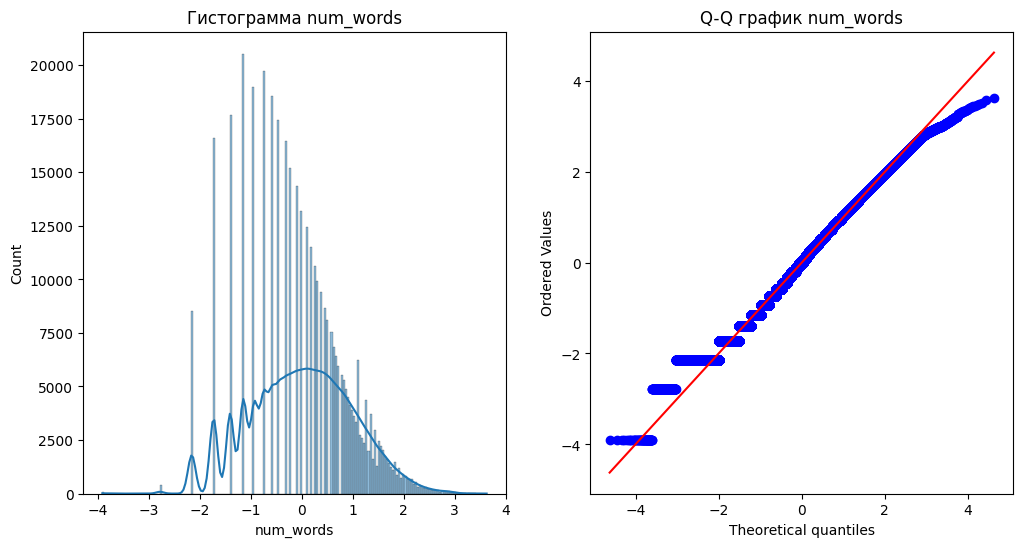

Тест Колмогорова-Смирнова для num_words: Статистика=0.039, p-значение=0.000
Распределение num_words не нормально (отвергаем H0)




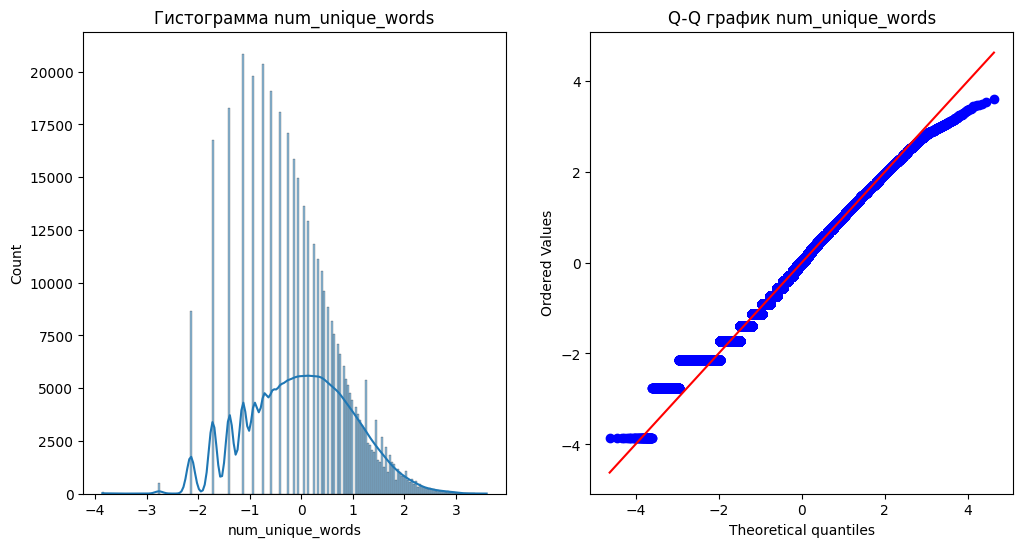

Тест Колмогорова-Смирнова для num_unique_words: Статистика=0.039, p-значение=0.000
Распределение num_unique_words не нормально (отвергаем H0)




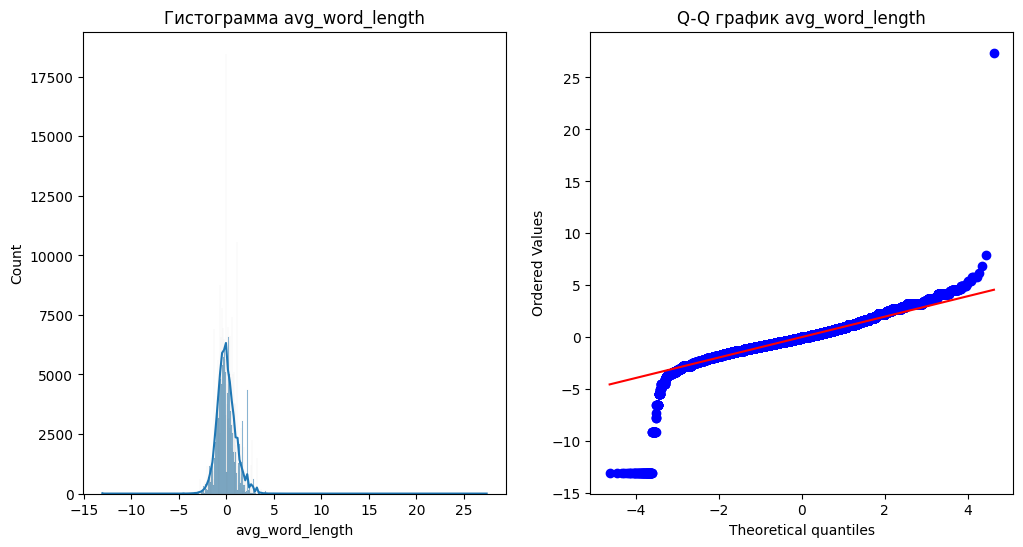

Тест Колмогорова-Смирнова для avg_word_length: Статистика=0.060, p-значение=0.000
Распределение avg_word_length не нормально (отвергаем H0)




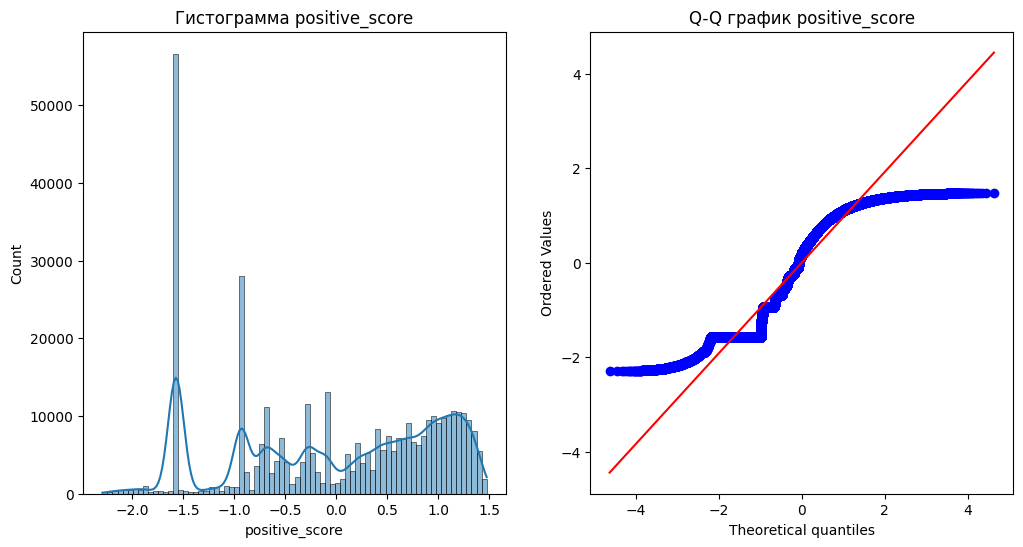

Тест Колмогорова-Смирнова для positive_score: Статистика=0.104, p-значение=0.000
Распределение positive_score не нормально (отвергаем H0)




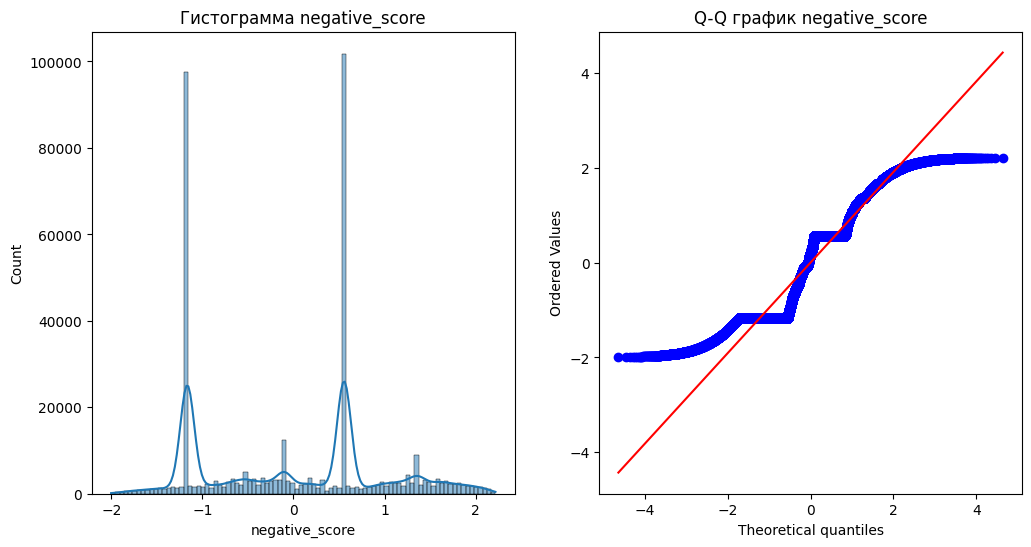

Тест Колмогорова-Смирнова для negative_score: Статистика=0.177, p-значение=0.000
Распределение negative_score не нормально (отвергаем H0)




In [808]:
# Проверяем нормальность для указанных столбцов после нормализации
check_normality(hotels, scaling_columns)

In [809]:
hotels[scaling_columns].describe()

,total_number_of_reviews,review_total_negative_word_counts,total_number_of_reviews_reviewer_has_given,review_total_positive_word_counts,average_score,additional_number_of_scoring,num_words,num_unique_words,avg_word_length,positive_score,negative_score
count,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05,3.868030e+05
mean,2.140144e-15,-2.110670e-16,-8.113865e-17,-2.424791e-18,-3.343135e-16,4.018907e-16,1.180731e-15,2.556639e-16,-4.144372e-16,-3.261344e-16,3.207337e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.475677e+00,-1.395592e+00,-1.208557e+00,-2.095818e+00,-3.637582e+00,-4.103889e+00,-3.906556e+00,-3.856623e+00,-1.304661e+01,-2.295338e+00,-2.002009e+00
25%,-6.756628e-01,-6.966168e-01,-1.208557e+00,-6.724091e-01,-6.220018e-01,-6.808917e-01,-7.452135e-01,-7.244855e-01,-6.497400e-01,-9.022382e-01,-1.166232e+00
50%,2.278666e-02,1.164442e-01,-1.000775e-01,-2.784560e-02,-8.470762e-02,1.582889e-02,-1.909226e-03,4.045191e-02,-6.938274e-02,1.956948e-01,1.722739e-01
75%,6.834172e-01,7.402988e-01,8.129845e-01,6.315573e-01,7.179227e-01,7.135073e-01,7.251521e-01,6.933987e-01,5.770429e-01,9.187702e-01,5.554391e-01
max,2.943461e+00,2.966459e+00,2.435244e+00,4.260035e+00,3.210961e+00,2.368741e+00,3.626852e+00,3.593272e+00,2.739285e+01,1.473454e+00,2.217304e+00


## Отбор признаков по критерию мультиколлинеарности

Проведём корреляционный анализ датасета и используем для этого тепловую карту корреляций признаков.


In [810]:
# Вычисляем корреляционную матрицу
numerical_hotels = hotels.select_dtypes(include=['number'])

# Вычисляем матрицу корреляции
correlation_matrix = numerical_hotels.corr()

# Создаем тепловую карту, используя Plotly
fig = px.imshow(correlation_matrix, 
                text_auto=True, 
                color_continuous_scale='Viridis', 
                title='Correlation Heatmap')

# Отображаем график
fig.show()

Вывод пар с высокой корреляцией (мультиколлинеарностью)

In [811]:
# Вычисляем матрицу корреляции
#correlation_matrix = hotels.corr()

# устанавливаем пороговое значение корреляции для мультиколлинеарности
limit_multicolinear_corr = 0.75

# Убираем дубликаты и оставляем только верхний треугольник
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
filtered_corr = correlation_matrix.where(mask)

# Извлекаем пары с коэффициентом корреляции больше 0.75
high_corr_pairs = filtered_corr.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation Coefficient']

# Фильтруем по значению корреляции
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation Coefficient'] > limit_multicolinear_corr]

# Проверяем результат
display(high_corr_pairs)

,Variable 1,Variable 2,Correlation Coefficient
2,additional_number_of_scoring,total_number_of_reviews,0.875821
318,lat,hotel_country_3,0.806349
810,num_words,num_unique_words,0.997460


In [812]:
# Функция для выбора признаков для исключения по признаку мультиколлинеарности
def select_features_to_exclude(high_corr_pairs):
    # Инициализируем множества для отслеживания признаков для исключения для обеих стратегий
    features_to_exclude_var1 = set()
    features_to_exclude_var2 = set()
    
    # Проходим по парам с высокой корреляцией для стратегии var1
    for index, row in high_corr_pairs.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        
        # Если ни один из признаков не находится в множестве исключений, добавляем var1
        if var1 not in features_to_exclude_var1 and var2 not in features_to_exclude_var1:
            features_to_exclude_var1.add(var1)
    
    # Проходим по парам с высокой корреляцией для стратегии var2
    for index, row in high_corr_pairs.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        
        # Если ни один из признаков не находится в множестве исключений, добавляем var2
        if var1 not in features_to_exclude_var2 and var2 not in features_to_exclude_var2:
            features_to_exclude_var2.add(var2)
    
    # Сравниваем длины обоих множеств и возвращаем меньшее или оба, если они равны
    if len(features_to_exclude_var1) < len(features_to_exclude_var2):
        return [list(features_to_exclude_var1)]
    elif len(features_to_exclude_var1) > len(features_to_exclude_var2):
        return [list(features_to_exclude_var2)]
    else:
        return [list(features_to_exclude_var1), list(features_to_exclude_var2)]

# Пример использования функции
features_to_exclude = select_features_to_exclude(high_corr_pairs)
display("Потенциальные признаки для исключения по критерию мультиколлинеарности:", features_to_exclude)

'Потенциальные признаки для исключения по критерию мультиколлинеарности:'

[['additional_number_of_scoring', 'lat', 'num_words'],
 ['num_unique_words', 'hotel_country_3', 'total_number_of_reviews']]

### Определяем признаки с сильной корреляционной связью (мультиколлинеарностью)

In [813]:
#multicolinear_cols = ['additional_number_of_scoring', 'num_words', 'num_unique_words']

# требуется проверка на итоговый результат MAPE
#multicolinear_cols = ['additional_number_of_scoring', 'num_words', 'num_unique_words', 'lat']

# при нормализваии PowerTransformer уменьшилось количество признаковв с мультиколлинеарностью
multicolinear_cols = ['additional_number_of_scoring', 'lat', 'num_words']

# удалим далее, чтобы удобнее было перезапускать модель
#hotels.drop(multicolinear_cols, axis = 1, inplace=True)

In [814]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

## Отбор признаков по значимости


Оцениваем значимость каждого признака для целевой переменной — рейтинга отеля reviewer_score.

Для оценки значимости категориальных признаков используем тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [815]:
# Выбираем все числовые столбцы
numeric_cols = hotels.select_dtypes(include=['number']).columns

# Исключаем бинарные столбцы (где значения только 0 и 1)
non_binary_numeric_cols = [col for col in numeric_cols if not hotels[col].isin([0, 1]).all()]

# Выбираем бинарные столбцы (где значения только 0 и 1)
binary_numeric_cols = [col for col in numeric_cols if hotels[col].isin([0, 1]).all()]

num_cols = non_binary_numeric_cols
cat_cols = binary_numeric_cols

display(f'Непрерывные числовые признаки {num_cols}')
display(f'Бинарные признаки {cat_cols}')

"Непрерывные числовые признаки ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'days_since_review', 'lat', 'lng', 'stayed_nights', 'review_year', 'review_month', 'review_day', 'season', 'day_of_week', 'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']"

"Бинарные признаки ['leisure_trip', 'business_trip', 'mobile_booking', 'solo_traveler', 'couple', 'group', 'family_with_young_children', 'family_with_older_children', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_country_0', 'hotel_country_1', 'hotel_country_2', 'hotel_country_3']"

In [816]:
# непрерывные числовые признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
       'total_number_of_reviews_reviewer_has_given',
       'review_total_positive_word_counts', 'average_score', 'days_since_review', 'stayed_nights',
       'additional_number_of_scoring', 'num_words', 'num_unique_words', 'avg_word_length', 
       'positive_score', 'negative_score']

# категориальные признаки
cat_cols = [ 'lat',  'season', 'day_of_week', 'leisure_trip', 'business_trip',
       'mobile_booking', 'solo_traveler', 'couple', 'group', 'review_day', 'review_month', 'review_year',
       'family_with_young_children', 'family_with_older_children',  
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_country_0',
       'hotel_country_1', 'hotel_country_2', 'hotel_country_3']

#Удаляем ранее удаленние признаки с сильной корреляционной связью (мультиколлинеарностью)
filtered_num_cols = [col for col in num_cols if col not in multicolinear_cols]
filtered_cat_cols = [col for col in cat_cols if col not in multicolinear_cols]


Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке ***sklearn.feature_selection.chi2***. 

Метод возвращает массив значений хи-квадрат и p-value для каждого признака.

Используем только значения хи-квадрат и выведем их на графике:

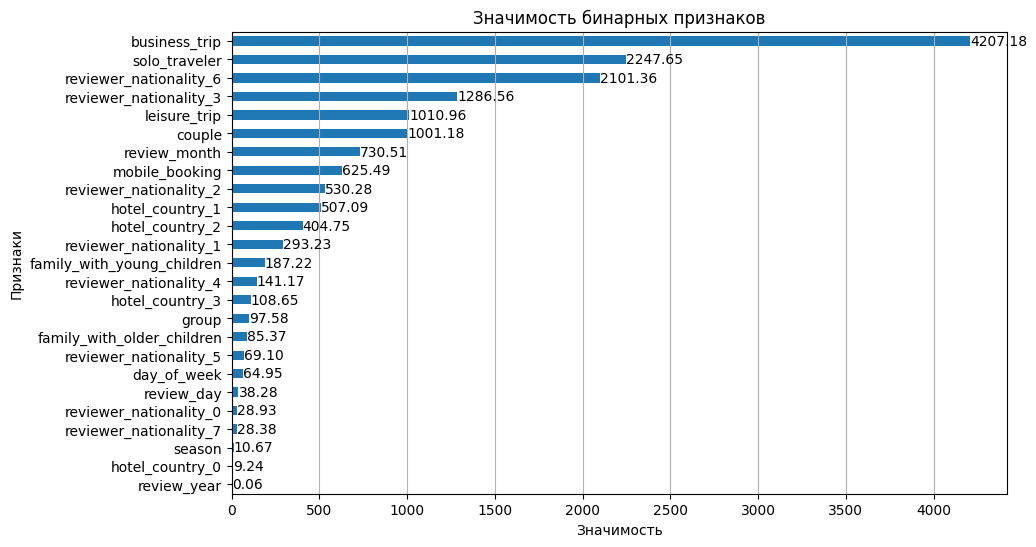

In [817]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
#X = hotels[cat_cols] 

y = hotels['reviewer_score'].round(2).astype('int')
#y = y.round(2).astype('int')

imp_cat = pd.Series(chi2(X[filtered_cat_cols], y)[0], index=filtered_cat_cols)
imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

plt.figure(figsize=(10, 6))
ax = imp_cat.plot(kind='barh')

# Добавляем подписи к графику
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + i.get_height()/2, 
            f'{i.get_width():.2f}', 
            va='center')  # Выравнивание по вертикали

# Настраиваем график
plt.title('Значимость бинарных признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(axis='x')

# Показываем график
plt.show()


Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

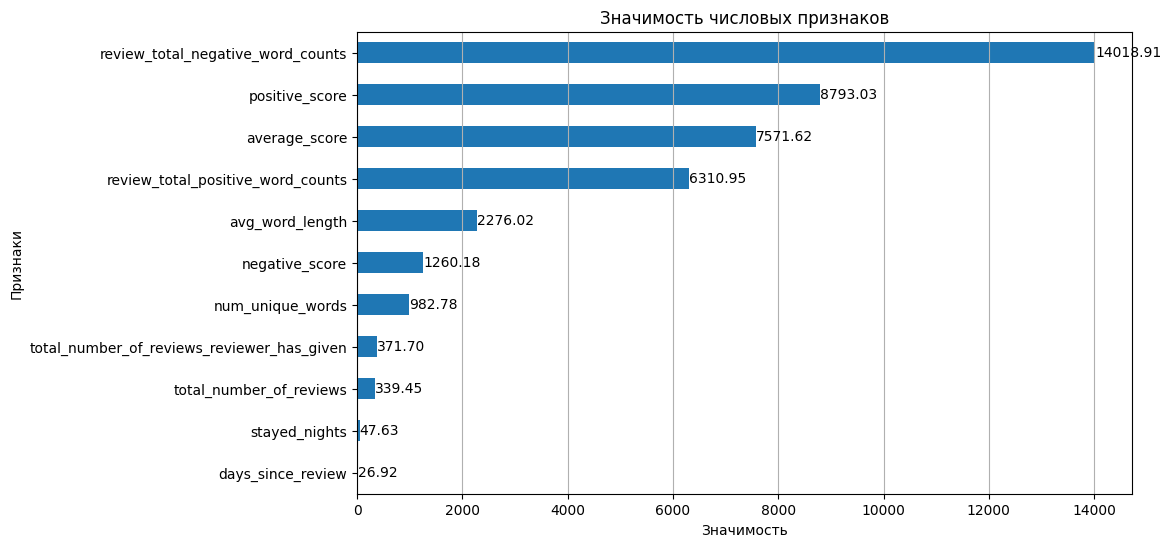

In [818]:
imp_num = pd.Series(f_classif(X[filtered_num_cols], y)[0], index = filtered_num_cols)
imp_num.sort_values(inplace = True)
#imp_num.plot(kind = 'barh')
# Строим график
plt.figure(figsize=(10, 6))
ax = imp_num.plot(kind='barh')

# Добавляем подписи к графику
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + i.get_height()/2, 
            f'{i.get_width():.2f}', 
            va='center')  # Выравнивание по вертикали

# Настраиваем график
plt.title('Значимость числовых признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(axis='x')

# Показываем график
plt.show()


In [819]:
# Устанавливаем порог значимости на уровне 25-го квантиля
threshold_cat = imp_cat.quantile(0.25)

# Выбираем признаки с низкой значимостью
low_importance_features_cat = imp_cat[imp_cat < threshold_cat]

# Проверяем результат
display("Кандидаты в Категориальные признаки с низкой значимостью:")
display(low_importance_features_cat)

'Кандидаты в Категориальные признаки с низкой значимостью:'

review_year                0.055775
hotel_country_0            9.241552
season                    10.673946
reviewer_nationality_7    28.383142
reviewer_nationality_0    28.930543
review_day                38.280350
dtype: float64

In [820]:
# Устанавливаем порог значимости на уровне 25-го квантиля
threshold_num = imp_num.quantile(0.25)

# Выбираем признаки с низкой значимостью
low_importance_features_num = imp_num[imp_num < threshold_num]

# Проверяем результат
display("Кандидаты в Числовые признаки с низкой значимостью:")
display(low_importance_features_num)

'Кандидаты в Числовые признаки с низкой значимостью:'

days_since_review           26.918686
stayed_nights               47.633196
total_number_of_reviews    339.449344
dtype: float64

## Удаление признаков
- признаков с мультиколлинеарностью,
- признаков с низкой значимостью, 
- признаков, которые не обрабатываются моделью - т.к. данные которых не являются числовыми

In [821]:
# Список мультиколлинеарных признаков для удаления
multicolinear_cols

['additional_number_of_scoring', 'lat', 'num_words']

In [822]:
# создаем копию датафрейма для передачи на этап ML
hotels_ml = hotels.copy()

#multicolinear_cols = ['additional_number_of_scoring', 'lat', 'num_words']
# Удаляем признаки с мультиколлинеарностью
hotels_ml.drop(multicolinear_cols, axis = 1, inplace=True)

# бинарные признаки с низкой значимостью
insignificant_cols_cat = ['review_year', 'season']

# числовые признаки с низкой значимостью
insignificant_cols_num = ['days_since_review', 'stayed_nights']

# Признаки с низкой значимостью
insignificant_cols = insignificant_cols_num + insignificant_cols_cat

hotels_ml.drop(insignificant_cols, axis = 1, inplace=True)

# убираем признаки, которые не обрабатываются моделью - dtypes "object", "datetime64"
# отбираем только значимые признаки
object_columns = [s for s in hotels_ml.columns if hotels_ml[s].dtypes == 'object']
hotels_ml.drop(object_columns, axis = 1, inplace=True)

datetime64_columns = [s for s in hotels_ml.columns if pd.api.types.is_datetime64_any_dtype(hotels_ml[s])]
hotels_ml.drop(datetime64_columns, axis = 1, inplace=True)

# Проверяем наличие пропусков в датасете hotel_ml перед созданием модели
missing_values = hotels_ml.isna().sum()
    
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel_ml: ')
    display(missing_values[missing_values > 0])
    # заполняем пропуски самым простым способом (на этом этапе их уже не должно быть, просто перестраховка)
    hotels_ml = hotels_ml.fillna(0) # заполняем пропуски нулями 
else:
    display('Пропусков NaN в датасете hotel_ml нет')

'Пропусков NaN в датасете hotel_ml нет'

## Создание модели

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 

In [823]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_ml.drop(['reviewer_score'], axis = 1)  
y = hotels_ml['reviewer_score'] 

In [824]:
# Загружаем специальный инструмент для разбивки:  
#from sklearn.model_selection import train_test_split  

In [825]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [ ]:
# # проверяем
#test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

## Обучение модели

In [826]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# ожидание 7-9 минут - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

## Анализ модели

In [827]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12494561446824948


### Примечания по метрике

**Предыдущие значения метрики**

MAPE: 0.12535604022312982

MAPE: 0.1252518013290165 - после удаления 2 дополнительных признаков с низкой значимостью - 'review_year', 'day_of_week'

MAPE: 0.12522880929005367 - заполнены пропуски признака reviewer_nationality модой

MAPE: 0.12518467984928733 - исправлена ошибка, когда в модель отправлялись все признаки без очистки от мультиколлинеаррности и низкой значимости, в расчет были взяты все прризнаки.

MAPE: 0.1252300403852055 - отмена удаления 2 дополнительных признаков с низкой значимостью - 'review_day', 'day_of_week'

MAPE: 0.12533206314154807 - отмена удаления 3 дополнительных признаков с низкой значимостью - 'review_day', 'day_of_week', 'season'


MAPE: 0.12542054975340974 - при использоввании нормализации MinMaxScaler вместо RobustScaler

MAPE: 0.12525001221227516 - при использовании нормализации PowerTransformer

MAPE: 0.12482383153680582 - при использовании нормализации PowerTransformer и корректировкой признаков с низкой значимостью

MAPE: 0.12499156847501065 - удалил признак 'lat' из модели

MAPE: 0.12494561446824948
